In [2]:
import models
import datasets
import loss_functions
import networks

import time
import numpy as np
import random
import os
import matplotlib.pyplot as plt

import torch

from importlib import reload
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

In [3]:
def show_image(arr, label=None):
    plt.pause(0.05)
    if label:
        plt.xlabel(label)
    plt.imshow(arr, cmap=plt.cm.gist_gray)

In [4]:
from numpy.linalg import norm
def euclidean_disance(x, y):
    return norm(x - y)


def most_common(arr):
    counts = np.bincount(arr)
    return np.argmax(counts)

In [5]:
def count_classes(images):
    positive, negative = 0, 0
    for image in images:
        if image.__contains__("False"):
            negative = negative + 1
        else:
            positive = positive + 1
    print("Positive = {}\nNegative = {}".format(positive,negative))


In [6]:
def predict_label(encoding, encodings, labels, k, paths=None):
    #pridat paths na ziskanie cesty k podobnym obrazkom
    distances = np.zeros(len(encodings))
    for indx, x in enumerate(encodings, 0):
        distance = euclidean_disance(encoding, x)
        distances[indx] = distance
    if paths is not None:
        zipped = list(zip(encodings, distances, labels, paths))
        zipped.sort(key=lambda t: t[1])
        zipped = zipped[1:k + 1]
        paths = np.array(zipped)[:,3]
        labels = np.array(zipped)[:, 2].astype(int)
        result = most_common(labels)
        return result, paths
    else:
        zipped = list(zip(encodings, distances, labels))
        zipped.sort(key=lambda t: t[1])
        zipped = zipped[1:k + 1]
        labels = np.array(zipped)[:, 2].astype(int)
        result = most_common(labels)
        return result

In [7]:
def plot_results(encodings, labels):
    color = ['blue' if label == 0 else 'red' for label in labels]
    plt.scatter(encodings[:, 0], encodings[:, 1], c=color)
    plt.xlabel("dim1")
    plt.ylabel("dim2")
    plt.show()

In [8]:
def print_scores(labels, predicted_labels):
    print("Accuracy: {}".format(accuracy_score(labels, predicted_labels)))
    print("Precision: {}".format(precision_score(labels, predicted_labels)))
    print("Recall: {}".format(recall_score(labels, predicted_labels)))
    print("F1: {}".format(f1_score(labels, predicted_labels)))

In [11]:
def print_conf_matrix(labels, predicted_labels):
    tn, fp, fn, tp = confusion_matrix(labels, predicted_labels).ravel()
    print("tn: {}\nfp: {}\nfn: {}\ntp: {}\n".format(tn,fp,fn,tp))

In [9]:
def plot_loss(loss_history):
    plt.xlabel("batch")
    plt.ylabel("loss")
    plt.plot(loss_history)
    plt.show()

In [10]:
def undersample(images):
    false_images = []
    true_images = []
    for image in images:
        false_images.append(image) if image.__contains__("False") else true_images.append(image)

    images = []
    if len(false_images) > len(true_images):
        false_images = false_images[0:len(true_images)]
        images = false_images
        images.extend(true_images)
        
    else:
        true_images = true_images[0:len(false_images)]
        images = true_images
        images.extend(false_images)
        
    return images

In [12]:
def eval_model(model, dataloader_train, dataloader_test):
    encodings, labels, paths = model.predict(dataloader_train)
    plot_results(encodings, labels)
    
    encodings, labels, paths = model.predict(dataloader_test)
    plot_results(encodings, labels)
    
    predicted_labels = []
    for encoding, label in (zip(encodings, labels)):
        predicted_labels.append(predict_label(encoding, encodings, labels, 3))

    predicted_labels = np.array(predicted_labels)
    print_conf_matrix(labels, predicted_labels)
    print_scores(labels, predicted_labels)
    return encodings, labels, paths

In [13]:
def validation(model, data, batch_size, path, split_factor=0.2):
        data = np.array(data)
        train, test = train_test_split(data, test_size=split_factor)
        dataset_train = datasets.SiameseDataset(path, train)
        dataset_test = datasets.SiameseDataset(path, test)
        dataloader_train = DataLoader(dataset_train, shuffle=1, num_workers=4, batch_size=batch_size, drop_last=True)
        loss_history = model.fit(dataloader_train)
        plot_loss(loss_history)
        dataloader_train_eval = DataLoader(dataset_train.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=batch_size, drop_last=False)
        dataloader_test_eval = DataLoader(dataset_test.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=batch_size, drop_last=False)
        eval_model(model, dataloader_train_eval, dataloader_test_eval)

In [14]:
def k_cross_validation(model, data, batch_size, path, k=5):
    data = np.array(data)
    kf = KFold(n_splits=k)
    torch.save(model.network,'./net')
    nfold = 1
    for train, test in kf.split(data):
        print("############### Fold number {} ###############\n".format(nfold))
        dataset_train = datasets.SiameseDataset(path, data[train])
        dataset_test = datasets.SiameseDataset(path, data[test])
        dataloader_train = DataLoader(dataset_train, shuffle=1, num_workers=4, batch_size=batch_size, drop_last=True)
        loss_history = model.fit(dataloader_train)
        plot_loss(loss_history)
        dataloader_train_eval = DataLoader(dataset_train.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=batch_size, drop_last=False)
        dataloader_test_eval = DataLoader(dataset_test.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=batch_size, drop_last=False)
        eval_model(model, dataloader_train_eval, dataloader_test_eval)
        model.network = torch.load('./net')
        nfold = nfold + 1


In [16]:
def train_loop(model, epochs, dataloader):
    for epoch in range(0, epochs):
        for i, data in enumerate(dataloader, 0):
            loss = model.fit(data)
            loss_sum = loss + loss_sum
            #print("Epoch no. {}\nBatch {}\nCurrent loss {}\n".format(epoch, i, loss_contrastive.item()))
            if i % 10 == 0:
                avg_loss = loss_sum / 10
                loss_history.append(avg_loss)
                loss_sum = 0
    return loss_history

In [15]:
def predict_loop(model, dataloader):
    encodings = []
    labels = []
    for epoch in range(0, epochs):
        for img, label, _ in enumerate(dataloader):
            encoding = models.predict(img)
            encodings.extend(encoding.numpy())
            labels.extend(label.numpy())
            
    return np.array(encodings), np.array(labels)
            

# TEST

In [19]:
path = '../Data/diff_ADC_BVAL_np_norm'
images = os.listdir(path)
random.shuffle(images)



In [92]:
train, test = train_test_split(images, test_size=0.3)
dataset_train = datasets.SiameseDataset(path, train)
dataset_test = datasets.SiameseDataset(path, test)
dataloader_train = DataLoader(dataset_train, shuffle=1, num_workers=4, batch_size=64, drop_last=True)

In [94]:
model = models.SiameseModel(2, 0.0001, networks.SiameseNet(networks.Net2DChannel2()).cuda(), loss_functions.ContrastiveLoss())
loss_history = model.fit(dataloader_train)

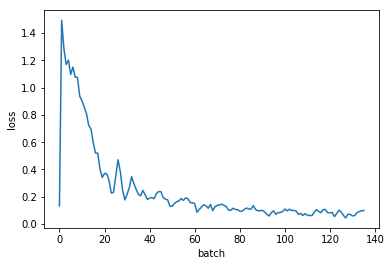

In [95]:
plot_loss(loss_history)


In [96]:
dataloader_train_eval = DataLoader(dataset_train.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=8, drop_last=False)
dataloader_test_eval = DataLoader(dataset_test.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=8, drop_last=False)

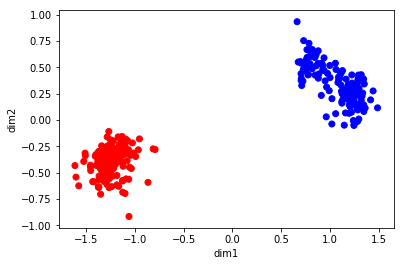

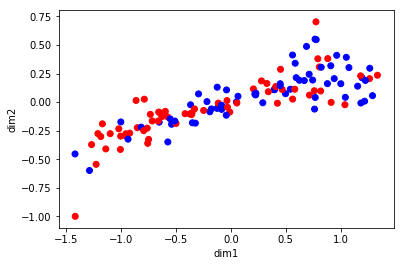

tn: 35
fp: 28
fn: 23
tp: 40

Accuracy: 0.5952380952380952
Precision: 0.5882352941176471
Recall: 0.6349206349206349
F1: 0.6106870229007633


In [97]:
encodings, real_labels, paths = eval_model(model, dataloader_train_eval, dataloader_test_eval)


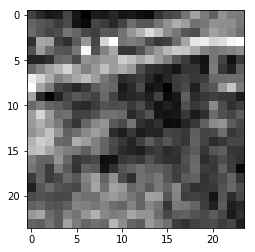

In [85]:
show_image(np.load(paths[0])[0])

In [86]:
predcited_label, similar_paths = predict_label(encoding=encodings[0], encodings=encodings, labels=real_labels, k=3, paths=paths)

In [83]:
real_labels[0]

0

In [79]:
predcited_label

1

In [87]:
similar_paths

array(['../Data/t2_tra_np_norm\\False FID 1 ProstateX-0020 IJK [157 231  10] DCM 5 H.npy',
       '../Data/t2_tra_np_norm\\True FID 1 ProstateX-0202 IJK [187 166  10] DCM 4.npy',
       '../Data/t2_tra_np_norm\\True FID 2 ProstateX-0179 IJK [191 215   5] DCM 5.npy'],
      dtype=object)

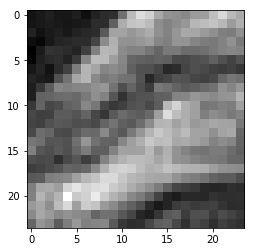

In [88]:
show_image(np.load('../Data/t2_tra_np_norm\\False FID 1 ProstateX-0020 IJK [157 231  10] DCM 5 H.npy')[0])

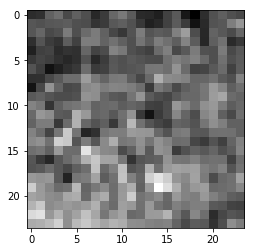

In [89]:
show_image(np.load('../Data/t2_tra_np_norm\\True FID 1 ProstateX-0202 IJK [187 166  10] DCM 4.npy')[0])

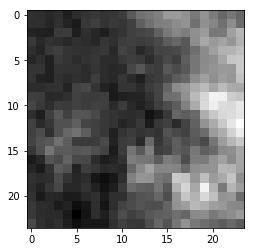

In [90]:
show_image(np.load('../Data/t2_tra_np_norm\\True FID 2 ProstateX-0179 IJK [191 215   5] DCM 5.npy')[0])

# T2

In [81]:
path = '../Data/t2_tra_np_norm'
images = os.listdir(path)
random.shuffle(images)


In [ ]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel1()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

In [ ]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel1()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)

# Diff

In [ ]:
path = '../Data/diff_ADC_BVAL_np_norm'
images = os.listdir(path)
random.shuffle(images)

In [ ]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel2()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

In [ ]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel2()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)

# T2 3D

In [ ]:
path = '../Data/t2_tra_np_3D_norm'
images = os.listdir(path)
random.shuffle(images)


In [ ]:
model = models.SiameseModel(3, 0.0001, networks.SiameseNet(networks.Net3DChannel1()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

In [ ]:
model = models.SiameseModel(3, 0.0001, networks.SiameseNet(networks.Net3DChannel1()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)

# Diff 3D

In [ ]:
path = '../Data/diff_ADC_BVAL_np_3D_norm'
images = os.listdir(path)
random.shuffle(images)


In [ ]:
model = models.SiameseModel(3, 0.0001, networks.SiameseNet(networks.Net3DChannel2()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

In [ ]:
model = models.SiameseModel(3, 0.0001, networks.SiameseNet(networks.Net3DChannel2()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)

# T2 Undersample

In [ ]:
path = '../Data/t2_tra_np_norm'
images = os.listdir(path)
images = undersample(images)
random.shuffle(images)


In [ ]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel1()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

end = time.time()

In [ ]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel1()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)

# Diff Undersample

In [ ]:
path = '../Data/diff_ADC_BVAL_np_norm'
images = os.listdir(path)
images = undersample(images)
random.shuffle(images)



In [ ]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel2()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

In [ ]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel2()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)

# T2 3D Undersample

In [ ]:
path = '../Data/t2_tra_np_3D_norm'
images = os.listdir(path)
images = undersample(images)
random.shuffle(images)

In [ ]:
model = models.SiameseModel(3, 0.0001, networks.SiameseNet(networks.Net3DChannel1()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

In [ ]:
model = models.SiameseModel(3, 0.0001, networks.SiameseNet(networks.Net3DChannel1()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)

# Diff 3D Undersample

In [ ]:
path = '../Data/diff_ADC_BVAL_np_3D_norm'
images = os.listdir(path)
images = undersample(images)
random.shuffle(images)


In [ ]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net3DChannel2()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

In [ ]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net3DChannel2()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)